In [1]:
#!pip install yfinance
#!pip install pandas-ta

In [2]:
import requests
import bs4 as bs
import pickle

import datetime as dt
import os

import pandas as pd
import pandas_datareader.data as pdr
import pandas_ta as ta

import numpy as np

import math

import yfinance as yf



In [3]:
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
#import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# GET THE TRADING DATA

In [4]:
#SPX500 data

df_analisys = yf.download('^GSPC',period="20d", interval="5m")
df_analisys = df_analisys.reset_index()

print(df_analisys.shape)
df_analisys

[*********************100%***********************]  1 of 1 completed
(1499, 7)


,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-02-02 09:30:00-05:00,4566.390137,4572.720215,4564.450195,4569.540039,4569.540039,0
1,2022-02-02 09:35:00-05:00,4569.569824,4578.430176,4569.240234,4576.879883,4576.879883,64841097
2,2022-02-02 09:40:00-05:00,4576.660156,4576.879883,4560.540039,4564.959961,4564.959961,58775578
3,2022-02-02 09:45:00-05:00,4564.890137,4566.299805,4555.000000,4555.000000,4555.000000,51093830
4,2022-02-02 09:50:00-05:00,4555.080078,4564.180176,4554.810059,4560.640137,4560.640137,42811041
...,...,...,...,...,...,...,...
1494,2022-03-02 10:30:00-05:00,4350.939941,4356.180176,4342.200195,4346.770020,4346.770020,45377650
1495,2022-03-02 10:35:00-05:00,4346.779785,4361.720215,4345.259766,4357.669922,4357.669922,38396971
1496,2022-03-02 10:40:00-05:00,4357.870117,4359.680176,4351.270020,4353.189941,4353.189941,29336321
1497,2022-03-02 10:45:00-05:00,4353.609863,4354.799805,4346.180176,4351.049805,4351.049805,26055070


In [5]:
df_analisys.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys.to_pickle(DIR_OUTPUTS + 'df_spx500_raw' + '.pkl')
print(df_analisys.shape)

(1499, 7)


# Candles computations

In [7]:
#Fixes the trading date
df_analisys['Datetime'] = df_analisys['Datetime'].dt.tz_localize(None)
df_analisys['Datetime']

0      2022-02-02 09:30:00
1      2022-02-02 09:35:00
2      2022-02-02 09:40:00
3      2022-02-02 09:45:00
4      2022-02-02 09:50:00
               ...        
1494   2022-03-02 10:30:00
1495   2022-03-02 10:35:00
1496   2022-03-02 10:40:00
1497   2022-03-02 10:45:00
1498   2022-03-02 10:49:38
Name: Datetime, Length: 1499, dtype: datetime64[ns]

In [8]:
df_analisys['date'] = df_analisys['Datetime'].apply(lambda x: x.date())
df_analisys['date']

0       2022-02-02
1       2022-02-02
2       2022-02-02
3       2022-02-02
4       2022-02-02
           ...    
1494    2022-03-02
1495    2022-03-02
1496    2022-03-02
1497    2022-03-02
1498    2022-03-02
Name: date, Length: 1499, dtype: object

In [9]:
#Computes body sizes

df_analisys['body_size'] = df_analisys['Close'] - df_analisys['Open']
df_analisys['abs_body_size'] = abs(df_analisys['body_size'])
df_analisys['upper_tail_size'] = df_analisys['High'] - df_analisys[['Open','Close']].max(axis=1)
df_analisys['lower_tail_size'] = df_analisys[['Open','Close']].min(axis=1) - df_analisys['Low']

df_analisys[0:50]

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size
0,2022-02-02 09:30:00,4566.390137,4572.720215,4564.450195,4569.540039,4569.540039,0,2022-02-02,3.149902,3.149902,3.180176,1.939941
1,2022-02-02 09:35:00,4569.569824,4578.430176,4569.240234,4576.879883,4576.879883,64841097,2022-02-02,7.310059,7.310059,1.550293,0.329590
2,2022-02-02 09:40:00,4576.660156,4576.879883,4560.540039,4564.959961,4564.959961,58775578,2022-02-02,-11.700195,11.700195,0.219727,4.419922
3,2022-02-02 09:45:00,4564.890137,4566.299805,4555.000000,4555.000000,4555.000000,51093830,2022-02-02,-9.890137,9.890137,1.409668,0.000000
4,2022-02-02 09:50:00,4555.080078,4564.180176,4554.810059,4560.640137,4560.640137,42811041,2022-02-02,5.560059,5.560059,3.540039,0.270020
5,2022-02-02 09:55:00,4561.180176,4564.009766,4554.799805,4559.870117,4559.870117,76891896,2022-02-02,-1.310059,1.310059,2.829590,5.070312
6,2022-02-02 10:00:00,4560.029785,4573.470215,4560.029785,4570.700195,4570.700195,46957710,2022-02-02,10.670410,10.670410,2.770020,0.000000
7,2022-02-02 10:05:00,4570.339844,4573.520020,4567.779785,4571.759766,4571.759766,38190963,2022-02-02,1.419922,1.419922,1.760254,2.560059
8,2022-02-02 10:10:00,4571.589844,4574.399902,4561.620117,4562.069824,4562.069824,39925664,2022-02-02,-9.520020,9.520020,2.810059,0.449707
9,2022-02-02 10:15:00,4562.100098,4565.500000,4557.459961,4564.060059,4564.060059,35204112,2022-02-02,1.959961,1.959961,1.439941,4.640137


In [10]:
#Computes candles color
df_analisys['body_disposal']=None
df_analisys.loc[df_analisys['body_size']>0,'body_disposal'] = 1
df_analisys.loc[df_analisys['body_size']<0,'body_disposal'] = 0

print(df_analisys['body_disposal'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))




   index  body_disposal
0    0.0            757
1    1.0            740
2    NaN              2


# Target signal

In [11]:
#Computes Target signal

nro_rows = len(df_analisys)
for i in range(0,nro_rows):
    
    profit_threshold = 30
    
    try:
        #Searches for the after indexes where the profit threshold is fullfilled 
        s_threshold = ((df_analisys['Close'][i] - df_analisys['Close'].iloc[i+1:]).abs() > profit_threshold)
        idxs = s_threshold[s_threshold].index
        
        try:
            target_idx = [min(idxs)]
        except:
            target_idx = []
        
        df_data = df_analisys.iloc[target_idx]

        Datetime = df_analisys['Datetime'][i]

        keepcols = ['Datetime','Close']
        df_data = df_data[keepcols]

        dic_rencols = {
            'Datetime':'target_date',
            'Close': 'target_close',
        }

        df_data = df_data.rename(columns=dic_rencols)
        df_data['Datetime'] = Datetime

        if i == 0:
            df_target =df_data.copy()
        else:
            df_target =df_target.append(df_data).copy()
            
    except:
        pass
        
df_target = df_target.reset_index(drop=True)
df_target

,target_date,target_close,Datetime
0,2022-02-03 09:30:00,4516.950195,2022-02-02 09:30:00
1,2022-02-02 11:10:00,4546.759766,2022-02-02 09:35:00
2,2022-02-03 09:30:00,4516.950195,2022-02-02 09:40:00
3,2022-02-02 14:40:00,4586.020020,2022-02-02 09:45:00
4,2022-02-02 15:15:00,4592.620117,2022-02-02 09:50:00
...,...,...,...
1479,2022-03-02 09:30:00,4328.049805,2022-03-01 15:45:00
1480,2022-03-02 09:40:00,4345.580078,2022-03-01 15:50:00
1481,2022-03-02 09:40:00,4345.580078,2022-03-01 15:55:00
1482,2022-03-02 10:35:00,4357.669922,2022-03-02 10:05:00


In [12]:
df_analisys_01 = pd.merge(df_analisys,
                         df_target,
                         on = ['Datetime'],
                         how = 'left').copy()

#Computes the target difference in closure prices
df_analisys_01['target_difference'] =  round( df_analisys_01['target_close'] - df_analisys_01['Close'] )

print(df_analisys.shape)
print(df_analisys_01.shape)

print(df_analisys_01['target_difference'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))

df_analisys_01

(1499, 13)
(1499, 16)
    index  target_difference
92 -120.0                  1
90 -119.0                  1
91 -118.0                  1
88 -114.0                  1
86 -113.0                  1
..    ...                ...
47   70.0                  4
96   72.0                  1
66   73.0                  2
95   76.0                  1
25    NaN                 15

[106 rows x 2 columns]


,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,target_date,target_close,target_difference
0,2022-02-02 09:30:00,4566.390137,4572.720215,4564.450195,4569.540039,4569.540039,0,2022-02-02,3.149902,3.149902,3.180176,1.939941,1,2022-02-03 09:30:00,4516.950195,-53.0
1,2022-02-02 09:35:00,4569.569824,4578.430176,4569.240234,4576.879883,4576.879883,64841097,2022-02-02,7.310059,7.310059,1.550293,0.329590,1,2022-02-02 11:10:00,4546.759766,-30.0
2,2022-02-02 09:40:00,4576.660156,4576.879883,4560.540039,4564.959961,4564.959961,58775578,2022-02-02,-11.700195,11.700195,0.219727,4.419922,0,2022-02-03 09:30:00,4516.950195,-48.0
3,2022-02-02 09:45:00,4564.890137,4566.299805,4555.000000,4555.000000,4555.000000,51093830,2022-02-02,-9.890137,9.890137,1.409668,0.000000,0,2022-02-02 14:40:00,4586.020020,31.0
4,2022-02-02 09:50:00,4555.080078,4564.180176,4554.810059,4560.640137,4560.640137,42811041,2022-02-02,5.560059,5.560059,3.540039,0.270020,1,2022-02-02 15:15:00,4592.620117,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,2022-03-02 10:30:00,4350.939941,4356.180176,4342.200195,4346.770020,4346.770020,45377650,2022-03-02,-4.169922,4.169922,5.240234,4.569824,0,NaT,NaN,NaN
1495,2022-03-02 10:35:00,4346.779785,4361.720215,4345.259766,4357.669922,4357.669922,38396971,2022-03-02,10.890137,10.890137,4.050293,1.520020,1,NaT,NaN,NaN
1496,2022-03-02 10:40:00,4357.870117,4359.680176,4351.270020,4353.189941,4353.189941,29336321,2022-03-02,-4.680176,4.680176,1.810059,1.919922,0,NaT,NaN,NaN
1497,2022-03-02 10:45:00,4353.609863,4354.799805,4346.180176,4351.049805,4351.049805,26055070,2022-03-02,-2.560059,2.560059,1.189941,4.869629,0,NaT,NaN,NaN


In [13]:
df_varbins = df_analisys_01[['target_difference']]
df_varbins['target_bins'] = pd.qcut(df_varbins['target_difference'], 20, duplicates='drop')
df_varbins['target_bins'] = df_varbins['target_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_bins'].astype(str)

print(df_varbins['target_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                    index  target_bins
18                 00-nan           15
8   01-(-120.001, -49.85]           75
7      02-(-49.85, -43.0]           78
3       03-(-43.0, -39.0]           97
5       04-(-39.0, -37.0]           89
16      05-(-37.0, -36.0]           52
9       06-(-36.0, -35.0]           74
6       07-(-35.0, -34.0]           87
4       08-(-34.0, -33.0]           90
2       09-(-33.0, -32.0]          121
0       10-(-32.0, -31.0]          150
12      11-(-31.0, -30.0]           70
1        12-(-30.0, 31.0]          122
15        13-(31.0, 32.0]           62
17        14-(32.0, 33.0]           43
13        15-(33.0, 35.0]           64
11        16-(35.0, 39.0]           73
14        17-(39.0, 48.0]           63
10        18-(48.0, 76.0]           74


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
#Computes the target difference in transcurred time
df_analisys_01['target_date_diff'] =  df_analisys_01['target_date'] - df_analisys_01['Datetime']
df_analisys_01['target_date_diff'] = df_analisys_01['target_date_diff'] / np.timedelta64(1,'m')

df_analisys_01

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,target_date,target_close,target_difference,target_date_diff
0,2022-02-02 09:30:00,4566.390137,4572.720215,4564.450195,4569.540039,4569.540039,0,2022-02-02,3.149902,3.149902,3.180176,1.939941,1,2022-02-03 09:30:00,4516.950195,-53.0,1440.0
1,2022-02-02 09:35:00,4569.569824,4578.430176,4569.240234,4576.879883,4576.879883,64841097,2022-02-02,7.310059,7.310059,1.550293,0.329590,1,2022-02-02 11:10:00,4546.759766,-30.0,95.0
2,2022-02-02 09:40:00,4576.660156,4576.879883,4560.540039,4564.959961,4564.959961,58775578,2022-02-02,-11.700195,11.700195,0.219727,4.419922,0,2022-02-03 09:30:00,4516.950195,-48.0,1430.0
3,2022-02-02 09:45:00,4564.890137,4566.299805,4555.000000,4555.000000,4555.000000,51093830,2022-02-02,-9.890137,9.890137,1.409668,0.000000,0,2022-02-02 14:40:00,4586.020020,31.0,295.0
4,2022-02-02 09:50:00,4555.080078,4564.180176,4554.810059,4560.640137,4560.640137,42811041,2022-02-02,5.560059,5.560059,3.540039,0.270020,1,2022-02-02 15:15:00,4592.620117,32.0,325.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,2022-03-02 10:30:00,4350.939941,4356.180176,4342.200195,4346.770020,4346.770020,45377650,2022-03-02,-4.169922,4.169922,5.240234,4.569824,0,NaT,NaN,NaN,NaN
1495,2022-03-02 10:35:00,4346.779785,4361.720215,4345.259766,4357.669922,4357.669922,38396971,2022-03-02,10.890137,10.890137,4.050293,1.520020,1,NaT,NaN,NaN,NaN
1496,2022-03-02 10:40:00,4357.870117,4359.680176,4351.270020,4353.189941,4353.189941,29336321,2022-03-02,-4.680176,4.680176,1.810059,1.919922,0,NaT,NaN,NaN,NaN
1497,2022-03-02 10:45:00,4353.609863,4354.799805,4346.180176,4351.049805,4351.049805,26055070,2022-03-02,-2.560059,2.560059,1.189941,4.869629,0,NaT,NaN,NaN,NaN


In [15]:
df_varbins = df_analisys_01[['target_date_diff']]
df_varbins['target_date_bins'] = pd.qcut(df_varbins['target_date_diff'], 20, duplicates='drop')
df_varbins['target_date_bins'] = df_varbins['target_date_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_date_bins'].astype(str)

print(df_varbins['target_date_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                   index  target_date_bins
20                00-nan                15
0       01-(9.999, 35.0]                94
5        02-(35.0, 50.0]                79
17       03-(50.0, 60.0]                65
18       04-(60.0, 70.0]                60
2        05-(70.0, 85.0]                85
3       06-(85.0, 100.0]                85
19     07-(100.0, 115.0]                53
1      08-(115.0, 145.0]                85
11     09-(145.0, 180.0]                73
15     10-(180.0, 210.0]                70
16    11-(210.0, 293.25]                67
4    12-(293.25, 1080.0]                80
14   13-(1080.0, 1125.0]                70
6    14-(1125.0, 1175.0]                76
7    15-(1175.0, 1230.0]                76
13   16-(1230.0, 1305.0]                72
10   17-(1305.0, 1395.0]                73
12   18-(1395.0, 3948.5]                72
9   19-(3948.5, 4169.25]                74
8   20-(4169.25, 5720.0]                75


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Computes high time to produce additional categories fo the target

df_varbins = df_varbins.sort_values(['target_date_diff'])
df_varbins = df_varbins[df_varbins.notna().all(axis=1)]
size = round(len(df_varbins)*(0.5))

high_time = df_varbins.iloc[size,:]['target_date_diff']
high_time

210.0

In [17]:
mean_time = df_varbins['target_date_diff'].median()
print('Mean awaiting time to profit: ', mean_time)

Mean awaiting time to profit:  210.0


In [18]:
#computes the target order movement
df_analisys_01['target_order'] = 'NULL'

df_analisys_01.loc[df_analisys_01['target_difference'] < 0, 'target_order'] = 'SELL'

df_analisys_01.loc[(df_analisys_01['target_difference'] < 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'SELL2'


df_analisys_01.loc[df_analisys_01['target_difference'] > 0, 'target_order'] = 'BUY'

df_analisys_01.loc[(df_analisys_01['target_difference'] > 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'BUY2'


df_analisys_01.loc[abs(df_analisys_01['target_difference']) < profit_threshold, 'target_order'] = 'NULL'

df_analisys_01['target_order_bin'] = 0
df_analisys_01.loc[df_analisys_01['target_order'] == 'BUY', 'target_order_bin'] = 1

print(df_analisys_01['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))
print(df_analisys_01['target_order_bin'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
2    BUY           307
3   BUY2           194
4   NULL            15
1   SELL           442
0  SELL2           541
   index  target_order_bin
0      0              1192
1      1               307


# MACD and EMA indicators

In [19]:
# # Calculate MACD values using the pandas_ta library
df_macd = df_analisys_01.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)
df_macd


,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
1494,8.552417,1.217052,7.335365
1495,9.711276,1.900729,7.810547
1496,10.151167,1.872496,8.278671
1497,10.209405,1.544587,8.664818


In [20]:
ewm50 = df_analisys_01['Close'].ewm(span=50, adjust=False, min_periods=50).mean()
ewm200 = df_analisys_01['Close'].ewm(span=200, adjust=False, min_periods=200).mean()

df_macd['ewm50'] = ewm50
df_macd['ewm200'] = ewm200

#df_analisys_01['ewm50'] = ewm50
#df_analisys_01['ewm200'] = ewm200

df_analisys_01['diff_ewm50'] = df_analisys_01['Close'] - ewm50
df_analisys_01['diff_ewm200'] = df_analisys_01['Close'] - ewm200

df_analisys_01

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,target_close,target_difference,target_date_diff,target_order,target_order_bin,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
0,2022-02-02 09:30:00,4566.390137,4572.720215,4564.450195,4569.540039,4569.540039,0,2022-02-02,3.149902,3.149902,...,4516.950195,-53.0,1440.0,SELL2,0,NaN,NaN,NaN,NaN,NaN
1,2022-02-02 09:35:00,4569.569824,4578.430176,4569.240234,4576.879883,4576.879883,64841097,2022-02-02,7.310059,7.310059,...,4546.759766,-30.0,95.0,SELL,0,NaN,NaN,NaN,NaN,NaN
2,2022-02-02 09:40:00,4576.660156,4576.879883,4560.540039,4564.959961,4564.959961,58775578,2022-02-02,-11.700195,11.700195,...,4516.950195,-48.0,1430.0,SELL2,0,NaN,NaN,NaN,NaN,NaN
3,2022-02-02 09:45:00,4564.890137,4566.299805,4555.000000,4555.000000,4555.000000,51093830,2022-02-02,-9.890137,9.890137,...,4586.020020,31.0,295.0,BUY2,0,NaN,NaN,NaN,NaN,NaN
4,2022-02-02 09:50:00,4555.080078,4564.180176,4554.810059,4560.640137,4560.640137,42811041,2022-02-02,5.560059,5.560059,...,4592.620117,32.0,325.0,BUY2,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,2022-03-02 10:30:00,4350.939941,4356.180176,4342.200195,4346.770020,4346.770020,45377650,2022-03-02,-4.169922,4.169922,...,NaN,NaN,NaN,NULL,0,8.552417,1.217052,7.335365,24.917719,22.131052
1495,2022-03-02 10:35:00,4346.779785,4361.720215,4345.259766,4357.669922,4357.669922,38396971,2022-03-02,10.890137,10.890137,...,NaN,NaN,NaN,NULL,0,9.711276,1.900729,7.810547,34.413009,32.702288
1496,2022-03-02 10:40:00,4357.870117,4359.680176,4351.270020,4353.189941,4353.189941,29336321,2022-03-02,-4.680176,4.680176,...,NaN,NaN,NaN,NULL,0,10.151167,1.872496,8.278671,28.759184,27.941489
1497,2022-03-02 10:45:00,4353.609863,4354.799805,4346.180176,4351.049805,4351.049805,26055070,2022-03-02,-2.560059,2.560059,...,NaN,NaN,NaN,NULL,0,10.209405,1.544587,8.664818,25.575163,25.544622


In [21]:
#Keeps only the data where MACD is available

df_analisys_02 = df_analisys_01[df_macd.notna().all(axis=1)]

#df_macd[df_macd.notna().all(axis=1)]

print(df_analisys_01.shape)
print(df_analisys_02.shape)

df_analisys_02

(1499, 24)
(1300, 24)


,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,target_close,target_difference,target_date_diff,target_order,target_order_bin,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
199,2022-02-04 13:05:00,4510.089844,4512.560059,4508.939941,4512.560059,4512.560059,19385000,2022-02-04,2.470215,2.470215,...,4474.160156,-38.0,4485.0,SELL2,0,7.117830,2.904201,4.213629,24.326375,-6.126056
200,2022-02-04 13:10:00,4512.419922,4514.189941,4509.359863,4510.790039,4510.790039,21736000,2022-02-04,-1.629883,1.629883,...,4474.160156,-37.0,4480.0,SELL2,0,7.789540,2.860728,4.928811,21.671793,-7.817508
201,2022-02-04 13:15:00,4510.819824,4511.810059,4507.129883,4508.669922,4508.669922,19124000,2022-02-04,-2.149902,2.149902,...,4474.160156,-35.0,4475.0,SELL2,0,8.057912,2.503281,5.554631,18.784943,-9.838743
202,2022-02-04 13:20:00,4508.810059,4516.319824,4508.310059,4516.319824,4516.319824,20646000,2022-02-04,7.509766,7.509766,...,4484.649902,-32.0,4220.0,SELL2,0,8.786596,2.585572,6.201024,25.398185,-2.167061
203,2022-02-04 13:25:00,4516.330078,4516.330078,4509.180176,4510.729980,4510.729980,17720000,2022-02-04,-5.600098,5.600098,...,4474.160156,-37.0,4465.0,SELL2,0,8.811457,2.088346,6.723111,19.031544,-7.679722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,2022-03-02 10:30:00,4350.939941,4356.180176,4342.200195,4346.770020,4346.770020,45377650,2022-03-02,-4.169922,4.169922,...,NaN,NaN,NaN,NULL,0,8.552417,1.217052,7.335365,24.917719,22.131052
1495,2022-03-02 10:35:00,4346.779785,4361.720215,4345.259766,4357.669922,4357.669922,38396971,2022-03-02,10.890137,10.890137,...,NaN,NaN,NaN,NULL,0,9.711276,1.900729,7.810547,34.413009,32.702288
1496,2022-03-02 10:40:00,4357.870117,4359.680176,4351.270020,4353.189941,4353.189941,29336321,2022-03-02,-4.680176,4.680176,...,NaN,NaN,NaN,NULL,0,10.151167,1.872496,8.278671,28.759184,27.941489
1497,2022-03-02 10:45:00,4353.609863,4354.799805,4346.180176,4351.049805,4351.049805,26055070,2022-03-02,-2.560059,2.560059,...,NaN,NaN,NaN,NULL,0,10.209405,1.544587,8.664818,25.575163,25.544622


# Data preparation

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Close price info

In [23]:
# Prepares previos close info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 80

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['Close']]
        Datetime = df_analisys_02.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['Close']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['Datetime'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss80_close_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    ###############################################################################################


    ###############################################################################################
    nro_close_lag2 = 160

    if i==0:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):,][['Close']]
    else:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):-i,][['Close']]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X2_ss = sscaler.fit_transform(X2)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss160_close_' + str(x) for x in range(len(X2_ss),0,-1) ]
    df_ssdata2 = pd.DataFrame(X2_ss.T,columns=ls_columns)

    # Keep anly a few of this standarization
    
    try:
        ls_keepcols = ['ss160_close_' + str(x) for x in range(20,0,-1) ]
        df_ssdata2 = df_ssdata2[ls_keepcols]
    except:
        pass
    ###############################################################################################


    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,7,20]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_close_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_close_info = pd.concat([df_ssdata,df_ssdata2,df_linregcoefs],axis=1,sort=False)
    df_close_info['Datetime'] = Datetime
    
    if i == 0:
        df_close_info_01 = df_close_info.copy()
    else:
        df_close_info_01 = df_close_info_01.append(df_close_info,sort=False).copy()
        
df_close_info_01 = df_close_info_01.reset_index(drop=True)
df_close_info_01

,ss80_close_80,ss80_close_79,ss80_close_78,ss80_close_77,ss80_close_76,ss80_close_75,ss80_close_74,ss80_close_73,ss80_close_72,ss80_close_71,...,ss160_close_5,ss160_close_4,ss160_close_3,ss160_close_2,ss160_close_1,slope_close_0,slope_close_1,slope_close_2,slope_close_3,Datetime
0,0.981887,1.177234,0.858748,1.337539,1.085405,1.501007,1.041344,1.324269,0.959597,0.117196,...,0.503768,0.950314,0.766779,0.679102,0.888462,0.078831,0.064547,0.164115,0.130577,2022-03-02 10:49:38
1,0.832331,1.019582,1.219315,0.893679,1.383219,1.125424,1.550357,1.080374,1.369651,0.996792,...,0.669942,0.508192,0.955674,0.771754,0.683893,-0.179646,0.038531,0.232305,0.147624,2022-03-02 10:45:00
2,1.525430,0.841178,1.029586,1.230553,0.902906,1.395470,1.136082,1.563640,1.090754,1.381818,...,-0.190705,0.674285,0.512307,0.960420,0.776241,0.175289,0.294883,0.306915,0.155806,2022-03-02 10:40:00
3,1.662805,1.539129,0.850372,1.040020,1.242310,0.912506,1.408313,1.147217,1.577590,1.101590,...,-0.210256,-0.186785,0.679821,0.517541,0.966491,0.191286,0.408077,0.304459,0.157833,2022-03-02 10:35:00
4,1.997437,1.675127,1.550738,0.858014,1.048754,1.252209,0.920505,1.419168,1.156569,1.589420,...,-0.352795,-0.203273,-0.179738,0.689276,0.526545,0.472681,0.354868,0.069460,0.152812,2022-03-02 10:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.290558,-0.398757,-1.224413,1.754758,-0.422146,0.401134,0.072811,NaN,NaN,2022-02-04 13:25:00
1296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.169303,-0.461450,-1.216961,1.509108,0.985279,NaN,NaN,NaN,2022-02-04 13:20:00
1297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.186404,0.073383,-1.259786,-1.223095,NaN,NaN,NaN,2022-02-04 13:15:00
1298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000,-1.000000,NaN,NaN,NaN,NaN,2022-02-04 13:10:00


In [24]:
df_close_info_01[[
    'ss80_close_1',
    'ss80_close_2',
    'ss80_close_3',
    'ss80_close_4',
    
    'ss160_close_1',
    'ss160_close_2',
    'ss160_close_3',
    'ss160_close_4',
]]


,ss80_close_1,ss80_close_2,ss80_close_3,ss80_close_4,ss160_close_1,ss160_close_2,ss160_close_3,ss160_close_4
0,2.023341,1.752079,1.865679,2.103481,0.888462,0.679102,0.766779,0.950314
1,1.807065,1.923216,2.166356,1.574790,0.683893,0.771754,0.955674,0.508192
2,1.938802,2.183445,1.588224,1.803376,0.776241,0.960420,0.512307,0.674285
3,2.201475,1.602336,1.818904,0.662388,0.966491,0.517541,0.679821,-0.186785
4,1.614309,1.832125,0.668946,0.637444,0.526545,0.689276,-0.179738,-0.203273
...,...,...,...,...,...,...,...,...
1295,-0.422146,1.754758,-1.224413,-0.398757,-0.422146,1.754758,-1.224413,-0.398757
1296,1.509108,-1.216961,-0.461450,0.169303,1.509108,-1.216961,-0.461450,0.169303
1297,-1.259786,0.073383,1.186404,NaN,-1.259786,0.073383,1.186404,NaN
1298,-1.000000,1.000000,NaN,NaN,-1.000000,1.000000,NaN,NaN


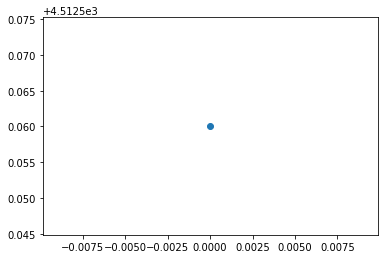

In [25]:
data = X
plt.scatter(range(0,len(data)), data)
plt.show()

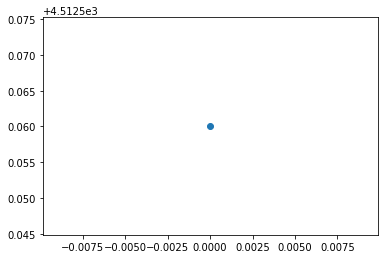

In [26]:
data = X2
plt.scatter(range(0,len(data)), data)
plt.show()

In [27]:
ls_ss160vars = ['ss160_close_' + str(x) for x in range(20,0,-1)]
ls_ss160vars

['ss160_close_20',
 'ss160_close_19',
 'ss160_close_18',
 'ss160_close_17',
 'ss160_close_16',
 'ss160_close_15',
 'ss160_close_14',
 'ss160_close_13',
 'ss160_close_12',
 'ss160_close_11',
 'ss160_close_10',
 'ss160_close_9',
 'ss160_close_8',
 'ss160_close_7',
 'ss160_close_6',
 'ss160_close_5',
 'ss160_close_4',
 'ss160_close_3',
 'ss160_close_2',
 'ss160_close_1']

In [28]:
ls_ss80vars = ['ss80_close_' + str(x) for x in range(80,9,-1) ]
ls_ss80vars

['ss80_close_80',
 'ss80_close_79',
 'ss80_close_78',
 'ss80_close_77',
 'ss80_close_76',
 'ss80_close_75',
 'ss80_close_74',
 'ss80_close_73',
 'ss80_close_72',
 'ss80_close_71',
 'ss80_close_70',
 'ss80_close_69',
 'ss80_close_68',
 'ss80_close_67',
 'ss80_close_66',
 'ss80_close_65',
 'ss80_close_64',
 'ss80_close_63',
 'ss80_close_62',
 'ss80_close_61',
 'ss80_close_60',
 'ss80_close_59',
 'ss80_close_58',
 'ss80_close_57',
 'ss80_close_56',
 'ss80_close_55',
 'ss80_close_54',
 'ss80_close_53',
 'ss80_close_52',
 'ss80_close_51',
 'ss80_close_50',
 'ss80_close_49',
 'ss80_close_48',
 'ss80_close_47',
 'ss80_close_46',
 'ss80_close_45',
 'ss80_close_44',
 'ss80_close_43',
 'ss80_close_42',
 'ss80_close_41',
 'ss80_close_40',
 'ss80_close_39',
 'ss80_close_38',
 'ss80_close_37',
 'ss80_close_36',
 'ss80_close_35',
 'ss80_close_34',
 'ss80_close_33',
 'ss80_close_32',
 'ss80_close_31',
 'ss80_close_30',
 'ss80_close_29',
 'ss80_close_28',
 'ss80_close_27',
 'ss80_close_26',
 'ss80_clo

In [29]:
ls_ss80vars2 = ['ss80_close_' + str(x) for x in range(9,0,-1) ]
ls_ss80vars2

['ss80_close_9',
 'ss80_close_8',
 'ss80_close_7',
 'ss80_close_6',
 'ss80_close_5',
 'ss80_close_4',
 'ss80_close_3',
 'ss80_close_2',
 'ss80_close_1']

In [30]:
ls_slopevars = ['slope_close_' + str(x) for x in range(0,4) ]
ls_slopevars

['slope_close_0', 'slope_close_1', 'slope_close_2', 'slope_close_3']

In [31]:
#Assigns correct format to variable to apply transformations
df_close_info_01[ls_ss80vars2] = df_close_info_01[ls_ss80vars2].astype(float)
df_close_info_01[ls_ss80vars] = df_close_info_01[ls_ss80vars].astype(float)
df_close_info_01[ls_ss160vars] = df_close_info_01[ls_ss160vars].astype(float)
df_close_info_01[ls_slopevars] = df_close_info_01[ls_slopevars].astype(float)

In [32]:
df_close_info_01 = df_close_info_01[df_close_info_01.notna().all(axis=1)]

df_close_info_01[ls_slopevars + ls_ss80vars2 + ls_ss80vars + ls_ss160vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1221 entries, 0 to 1220
Columns: 104 entries, slope_close_0 to ss160_close_1
dtypes: float64(104)
memory usage: 1001.6 KB


In [33]:
#Defines X vector to all process

X = df_close_info_01[ls_ss80vars + ls_ss160vars + ls_slopevars + ls_ss80vars2]
print(X.shape)

#y = df_analysis_01[Target_desc]
#y = df_analysis_02[Target_desc + '_coded']
#print(y.shape)

(1221, 104)


In [34]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss80vars2),
                                     ("pca1", pca_pip, ls_ss80vars),
                                     ("pca2", pca_pip, ls_ss160vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [35]:
Xtr.shape

(1221, 19)

In [36]:
#Defines the df of all transformations

ls_ss80pcavars = ['ss80_close_c1','ss80_close_c2','ss80_close_c3']
ls_ss160pcavars = ['ss160_close_c1','ss160_close_c2','ss160_close_c3']

df_close_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss80vars2 + ls_ss80pcavars + ls_ss160pcavars)
print(df_close_info_tr_01.shape)
df_close_info_tr_01

(1221, 19)


,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss80_close_9,ss80_close_8,ss80_close_7,ss80_close_6,ss80_close_5,ss80_close_4,ss80_close_3,ss80_close_2,ss80_close_1,ss80_close_c1,ss80_close_c2,ss80_close_c3,ss160_close_c1,ss160_close_c2,ss160_close_c3
0,0.078831,0.064547,0.164115,0.130577,0.394809,0.586968,0.617215,1.734039,1.524904,2.103481,1.865679,1.752079,2.023341,1.030808,4.739618,0.415645,2.319314,-2.241825,0.841945
1,-0.179646,0.038531,0.232305,0.147624,0.521906,0.419323,0.615797,0.646722,1.788621,1.574790,2.166356,1.923216,1.807065,0.606791,4.776555,0.455316,1.806333,-2.582527,1.322417
2,0.175289,0.294883,0.306915,0.155806,1.873822,0.528836,0.425620,0.623307,0.654424,1.803376,1.588224,2.183445,1.938802,-0.115812,4.633489,0.160484,1.390988,-2.830333,1.525639
3,0.191286,0.408077,0.304459,0.157833,1.463280,1.889814,0.535973,0.432077,0.631066,0.662388,1.818904,1.602336,2.201475,-0.806067,4.533826,-0.099214,0.952031,-2.975766,1.625788
4,0.472681,0.354868,0.069460,0.152812,1.669593,1.474452,1.903443,0.541804,0.437309,0.637444,0.668946,1.832125,1.614309,-1.584203,4.420353,-0.448543,0.461092,-3.009472,1.672896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,0.146665,0.045783,0.086281,0.050602,-1.337628,-1.371109,-0.989187,-0.696584,-0.441969,-0.620643,-0.637038,-0.359339,-0.343708,-4.519734,-2.728728,0.991654,-3.079041,-1.866818,-0.954187
1217,0.130410,0.047853,0.136017,0.043202,-1.238344,-1.347599,-1.381018,-0.999803,-0.707741,-0.453598,-0.631941,-0.648306,-0.371121,-4.329010,-2.898553,0.895679,-3.328653,-1.647589,-0.971340
1218,-0.097436,0.077945,0.148062,0.034229,-1.479206,-1.244931,-1.354279,-1.387726,-1.006189,-0.713880,-0.459522,-0.638016,-0.654395,-4.004125,-3.094095,0.930289,-3.570263,-1.394648,-0.888102
1219,0.038024,0.205106,0.153376,0.032897,-1.883010,-1.493810,-1.258965,-1.368579,-1.402107,-1.019642,-0.726623,-0.471646,-0.650574,-3.650200,-3.208883,0.994982,-3.826784,-1.312807,-0.685270


In [37]:
# Concat the Datetime to the transformed data

df_close_info_tr_01 = pd.concat([df_close_info_01['Datetime'],df_close_info_tr_01],axis=1)
df_close_info_tr_01

,Datetime,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss80_close_9,ss80_close_8,ss80_close_7,ss80_close_6,ss80_close_5,ss80_close_4,ss80_close_3,ss80_close_2,ss80_close_1,ss80_close_c1,ss80_close_c2,ss80_close_c3,ss160_close_c1,ss160_close_c2,ss160_close_c3
0,2022-03-02 10:49:38,0.078831,0.064547,0.164115,0.130577,0.394809,0.586968,0.617215,1.734039,1.524904,2.103481,1.865679,1.752079,2.023341,1.030808,4.739618,0.415645,2.319314,-2.241825,0.841945
1,2022-03-02 10:45:00,-0.179646,0.038531,0.232305,0.147624,0.521906,0.419323,0.615797,0.646722,1.788621,1.574790,2.166356,1.923216,1.807065,0.606791,4.776555,0.455316,1.806333,-2.582527,1.322417
2,2022-03-02 10:40:00,0.175289,0.294883,0.306915,0.155806,1.873822,0.528836,0.425620,0.623307,0.654424,1.803376,1.588224,2.183445,1.938802,-0.115812,4.633489,0.160484,1.390988,-2.830333,1.525639
3,2022-03-02 10:35:00,0.191286,0.408077,0.304459,0.157833,1.463280,1.889814,0.535973,0.432077,0.631066,0.662388,1.818904,1.602336,2.201475,-0.806067,4.533826,-0.099214,0.952031,-2.975766,1.625788
4,2022-03-02 10:30:00,0.472681,0.354868,0.069460,0.152812,1.669593,1.474452,1.903443,0.541804,0.437309,0.637444,0.668946,1.832125,1.614309,-1.584203,4.420353,-0.448543,0.461092,-3.009472,1.672896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,2022-02-07 13:30:00,0.146665,0.045783,0.086281,0.050602,-1.337628,-1.371109,-0.989187,-0.696584,-0.441969,-0.620643,-0.637038,-0.359339,-0.343708,-4.519734,-2.728728,0.991654,-3.079041,-1.866818,-0.954187
1217,2022-02-07 13:25:00,0.130410,0.047853,0.136017,0.043202,-1.238344,-1.347599,-1.381018,-0.999803,-0.707741,-0.453598,-0.631941,-0.648306,-0.371121,-4.329010,-2.898553,0.895679,-3.328653,-1.647589,-0.971340
1218,2022-02-07 13:20:00,-0.097436,0.077945,0.148062,0.034229,-1.479206,-1.244931,-1.354279,-1.387726,-1.006189,-0.713880,-0.459522,-0.638016,-0.654395,-4.004125,-3.094095,0.930289,-3.570263,-1.394648,-0.888102
1219,2022-02-07 13:15:00,0.038024,0.205106,0.153376,0.032897,-1.883010,-1.493810,-1.258965,-1.368579,-1.402107,-1.019642,-0.726623,-0.471646,-0.650574,-3.650200,-3.208883,0.994982,-3.826784,-1.312807,-0.685270


## MACD info

### Histogram

In [38]:
for c in df_analisys_02.columns.tolist():
    print(c)

Datetime
Open
High
Low
Close
Adj Close
Volume
date
body_size
abs_body_size
upper_tail_size
lower_tail_size
body_disposal
target_date
target_close
target_difference
target_date_diff
target_order
target_order_bin
MACD_12_26_9
MACDh_12_26_9
MACDs_12_26_9
diff_ewm50
diff_ewm200


In [39]:
# Prepares previos MACD H info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 80

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['MACDh_12_26_9']]
        Datetime = df_analisys_02.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['MACDh_12_26_9']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['Datetime'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss80_macdh_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    ###############################################################################################


    ###############################################################################################
    nro_close_lag2 = 160

    if i==0:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):,][['MACDh_12_26_9']]
    else:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):-i,][['MACDh_12_26_9']]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X2_ss = sscaler.fit_transform(X2)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss160_macdh_' + str(x) for x in range(len(X2_ss),0,-1) ]
    df_ssdata2 = pd.DataFrame(X2_ss.T,columns=ls_columns)

    # Keep anly a few of this standarization
    
    try:
        ls_keepcols = ['ss160_macdh_' + str(x) for x in range(20,0,-1) ]
        df_ssdata2 = df_ssdata2[ls_keepcols]
    except:
        pass
    ###############################################################################################


    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,7,20]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_macdh_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_macdh_info = pd.concat([df_ssdata,df_ssdata2,df_linregcoefs],axis=1,sort=False)
    df_macdh_info['Datetime'] = Datetime
    
    if i == 0:
        df_macdh_info_01 = df_macdh_info.copy()
    else:
        df_macdh_info_01 = df_macdh_info_01.append(df_macdh_info,sort=False).copy()
        
df_macdh_info_01 = df_macdh_info_01.reset_index(drop=True)
df_macdh_info_01

,ss80_macdh_80,ss80_macdh_79,ss80_macdh_78,ss80_macdh_77,ss80_macdh_76,ss80_macdh_75,ss80_macdh_74,ss80_macdh_73,ss80_macdh_72,ss80_macdh_71,...,ss160_macdh_5,ss160_macdh_4,ss160_macdh_3,ss160_macdh_2,ss160_macdh_1,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,Datetime
0,-1.486069,-1.386093,-1.431100,-1.141446,-1.040178,-0.708290,-0.709280,-0.526153,-0.577670,-1.024352,...,0.333317,0.618970,0.607173,0.470167,0.453721,-0.080506,0.009654,0.090768,0.028169,2022-03-02 10:49:38
1,-1.344351,-1.447949,-1.348951,-1.393518,-1.106698,-1.006422,-0.677782,-0.678762,-0.497427,-0.548440,...,0.260388,0.339522,0.625089,0.613296,0.476331,-0.077302,0.073339,0.104538,0.049962,2022-03-02 10:45:00
2,-0.919331,-1.321105,-1.424351,-1.325689,-1.370104,-1.084257,-0.984321,-0.656796,-0.657773,-0.477053,...,-0.102955,0.268719,0.347692,0.632679,0.620910,0.141785,0.188033,0.064274,0.065421,2022-03-02 10:40:00
3,-0.764190,-0.900174,-1.301771,-1.404971,-1.306353,-1.350749,-1.065028,-0.965136,-0.637755,-0.638731,...,0.162246,-0.091065,0.279328,0.358029,0.642034,0.188791,0.146645,-0.065544,0.075325,2022-03-02 10:35:00
4,-0.597452,-0.748132,-0.884292,-1.286407,-1.389741,-1.290995,-1.335449,-1.049358,-0.949338,-0.621534,...,0.534239,0.174670,-0.077210,0.291091,0.369347,0.234059,-0.022366,-0.265430,0.080755,2022-03-02 10:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.075285,0.927252,-0.289937,-0.009717,-1.702883,-0.706473,-0.649330,NaN,NaN,2022-02-04 13:25:00
1296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.107804,0.855341,-1.220523,-0.742621,-0.798981,NaN,NaN,NaN,2022-02-04 13:20:00
1297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.824653,0.582641,-1.407294,-1.115974,NaN,NaN,NaN,2022-02-04 13:15:00
1298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000,-1.000000,NaN,NaN,NaN,NaN,2022-02-04 13:10:00


In [40]:
# Create variable names lists to naming columns

ls_ss160vars = ['ss160_macdh_' + str(x) for x in range(20,0,-1)]
ls_ss160vars

ls_ss80vars = ['ss80_macdh_' + str(x) for x in range(80,9,-1) ]
ls_ss80vars

ls_ss80vars2 = ['ss80_macdh_' + str(x) for x in range(9,0,-1) ]
ls_ss80vars2

ls_slopevars = ['slope_macdh_' + str(x) for x in range(0,4) ]
ls_slopevars


['slope_macdh_0', 'slope_macdh_1', 'slope_macdh_2', 'slope_macdh_3']

In [41]:
#Assigns correct format to variable to apply transformations
df_macdh_info_01[ls_ss80vars2] = df_macdh_info_01[ls_ss80vars2].astype(float)
df_macdh_info_01[ls_ss80vars] = df_macdh_info_01[ls_ss80vars].astype(float)
df_macdh_info_01[ls_ss160vars] = df_macdh_info_01[ls_ss160vars].astype(float)
df_macdh_info_01[ls_slopevars] = df_macdh_info_01[ls_slopevars].astype(float)

In [42]:
df_macdh_info_01 = df_macdh_info_01[df_macdh_info_01.notna().all(axis=1)]

df_macdh_info_01[ls_slopevars + ls_ss80vars2 + ls_ss80vars + ls_ss160vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1221 entries, 0 to 1220
Columns: 104 entries, slope_macdh_0 to ss160_macdh_1
dtypes: float64(104)
memory usage: 1001.6 KB


In [43]:
#Defines X vector to all process

X = df_macdh_info_01[ls_ss80vars + ls_ss160vars + ls_slopevars + ls_ss80vars2]
print(X.shape)

#y = df_analysis_01[Target_desc]
#y = df_analysis_02[Target_desc + '_coded']
#print(y.shape)

(1221, 104)


In [44]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss80vars2),
                                     ("pca1", pca_pip, ls_ss80vars),
                                     ("pca2", pca_pip, ls_ss160vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [45]:
Xtr.shape

(1221, 19)

In [46]:
#Defines the df of all transformations

ls_ss80pcavars = ['ss80_macdh_c1','ss80_macdh_c2','ss80_macdh_c3']
ls_ss160pcavars = ['ss160_macdh_c1','ss160_macdh_c2','ss160_macdh_c3']

df_macdh_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss80vars2 + ls_ss80pcavars + ls_ss160pcavars)
print(df_macdh_info_tr_01.shape)
df_macdh_info_tr_01

(1221, 19)


,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,ss80_macdh_9,ss80_macdh_8,ss80_macdh_7,ss80_macdh_6,ss80_macdh_5,ss80_macdh_4,ss80_macdh_3,ss80_macdh_2,ss80_macdh_1,ss80_macdh_c1,ss80_macdh_c2,ss80_macdh_c3,ss160_macdh_c1,ss160_macdh_c2,ss160_macdh_c3
0,-0.080506,0.009654,0.090768,0.028169,0.571964,0.190338,-0.076993,0.313901,0.396957,0.696682,0.684304,0.540549,0.523293,2.278275,-0.327143,-4.971589,-3.238827,-0.061153,1.713976
1,-0.077302,0.073339,0.104538,0.049962,1.252796,0.589942,0.212052,-0.052663,0.334405,0.416649,0.713440,0.701183,0.558835,2.332898,-0.586118,-4.892330,-3.142568,0.640984,2.448573
2,0.141785,0.188033,0.064274,0.065421,2.085505,1.267234,0.606628,0.230019,-0.033798,0.351958,0.433923,0.729707,0.717492,2.365473,-0.983179,-4.726540,-2.998799,1.265618,2.764190
3,0.188791,0.146645,-0.065544,0.075325,2.107970,2.103337,1.285427,0.625113,0.248669,-0.015031,0.370554,0.452483,0.748137,2.345263,-1.402107,-4.571832,-2.799994,1.786105,2.703899
4,0.234059,-0.022366,-0.265430,0.080755,2.268679,2.127737,2.123099,1.304132,0.642965,0.266036,0.001994,0.388078,0.470112,2.269030,-1.847456,-4.406916,-2.568565,2.189192,2.210784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,0.039992,0.025059,0.111752,0.132855,0.637678,0.711314,0.983217,1.312297,1.635796,1.687354,1.655530,1.738507,1.735513,-3.185990,-0.961850,1.937306,-1.858991,3.059527,-0.926817
1217,0.025426,0.086701,0.170462,0.136394,0.502096,0.630734,0.703935,0.974233,1.301370,1.622960,1.674214,1.642578,1.725065,-3.392159,-0.907866,2.161993,-1.414595,3.138559,-0.781601
1218,0.009765,0.170192,0.199992,0.137119,0.224591,0.497413,0.625479,0.698355,0.967449,1.293131,1.613289,1.664314,1.632819,-3.596501,-0.791309,2.336313,-0.954748,3.173552,-0.557439
1219,0.183380,0.254704,0.214241,0.134012,0.048810,0.215560,0.485130,0.611670,0.683677,0.949564,1.271364,1.587706,1.638124,-3.770868,-0.652239,2.487795,-0.490172,3.163076,-0.313701


In [47]:
# Concat the Datetime to the transformed data

df_macdh_info_tr_01 = pd.concat([df_macdh_info_01['Datetime'],df_macdh_info_tr_01],axis=1)
df_macdh_info_tr_01

,Datetime,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,ss80_macdh_9,ss80_macdh_8,ss80_macdh_7,ss80_macdh_6,ss80_macdh_5,ss80_macdh_4,ss80_macdh_3,ss80_macdh_2,ss80_macdh_1,ss80_macdh_c1,ss80_macdh_c2,ss80_macdh_c3,ss160_macdh_c1,ss160_macdh_c2,ss160_macdh_c3
0,2022-03-02 10:49:38,-0.080506,0.009654,0.090768,0.028169,0.571964,0.190338,-0.076993,0.313901,0.396957,0.696682,0.684304,0.540549,0.523293,2.278275,-0.327143,-4.971589,-3.238827,-0.061153,1.713976
1,2022-03-02 10:45:00,-0.077302,0.073339,0.104538,0.049962,1.252796,0.589942,0.212052,-0.052663,0.334405,0.416649,0.713440,0.701183,0.558835,2.332898,-0.586118,-4.892330,-3.142568,0.640984,2.448573
2,2022-03-02 10:40:00,0.141785,0.188033,0.064274,0.065421,2.085505,1.267234,0.606628,0.230019,-0.033798,0.351958,0.433923,0.729707,0.717492,2.365473,-0.983179,-4.726540,-2.998799,1.265618,2.764190
3,2022-03-02 10:35:00,0.188791,0.146645,-0.065544,0.075325,2.107970,2.103337,1.285427,0.625113,0.248669,-0.015031,0.370554,0.452483,0.748137,2.345263,-1.402107,-4.571832,-2.799994,1.786105,2.703899
4,2022-03-02 10:30:00,0.234059,-0.022366,-0.265430,0.080755,2.268679,2.127737,2.123099,1.304132,0.642965,0.266036,0.001994,0.388078,0.470112,2.269030,-1.847456,-4.406916,-2.568565,2.189192,2.210784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,2022-02-07 13:30:00,0.039992,0.025059,0.111752,0.132855,0.637678,0.711314,0.983217,1.312297,1.635796,1.687354,1.655530,1.738507,1.735513,-3.185990,-0.961850,1.937306,-1.858991,3.059527,-0.926817
1217,2022-02-07 13:25:00,0.025426,0.086701,0.170462,0.136394,0.502096,0.630734,0.703935,0.974233,1.301370,1.622960,1.674214,1.642578,1.725065,-3.392159,-0.907866,2.161993,-1.414595,3.138559,-0.781601
1218,2022-02-07 13:20:00,0.009765,0.170192,0.199992,0.137119,0.224591,0.497413,0.625479,0.698355,0.967449,1.293131,1.613289,1.664314,1.632819,-3.596501,-0.791309,2.336313,-0.954748,3.173552,-0.557439
1219,2022-02-07 13:15:00,0.183380,0.254704,0.214241,0.134012,0.048810,0.215560,0.485130,0.611670,0.683677,0.949564,1.271364,1.587706,1.638124,-3.770868,-0.652239,2.487795,-0.490172,3.163076,-0.313701


### MACD model info

In [48]:
# Prepares previos MACD model info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 320

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['MACD_12_26_9']]
        Datetime = df_analisys_02.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['MACD_12_26_9']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['Datetime'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss320_macd_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    
    try:
        ls_keepcols = ['ss320_macd_' + str(x) for x in range(80,0,-1) ]
        df_ssdata = df_ssdata[ls_keepcols]
    except:
        pass
    ###############################################################################################



    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,7,20]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_macd_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_macd_info = pd.concat([df_ssdata,df_linregcoefs],axis=1,sort=False)
    df_macd_info['Datetime'] = Datetime
    
    if i == 0:
        df_macd_info_01 = df_macd_info.copy()
    else:
        df_macd_info_01 = df_macd_info_01.append(df_macd_info,sort=False).copy()
        
df_macd_info_01 = df_macd_info_01.reset_index(drop=True)
df_macd_info_01

,ss320_macd_80,ss320_macd_79,ss320_macd_78,ss320_macd_77,ss320_macd_76,ss320_macd_75,ss320_macd_74,ss320_macd_73,ss320_macd_72,ss320_macd_71,...,ss320_macd_5,ss320_macd_4,ss320_macd_3,ss320_macd_2,ss320_macd_1,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,Datetime
0,-0.339662,-0.388573,-0.473463,-0.464610,-0.493309,-0.449794,-0.482991,-0.463247,-0.500504,-0.654475,...,0.628575,0.745568,0.789978,0.795857,0.829874,0.019948,0.045289,0.060605,0.069733,2022-03-02 10:49:38
1,-0.223582,-0.324169,-0.372506,-0.456398,-0.447650,-0.476012,-0.433008,-0.465815,-0.446303,-0.483122,...,0.583439,0.632697,0.748317,0.792205,0.798016,0.024849,0.058866,0.058098,0.072384,2022-03-02 10:45:00
2,-0.047475,-0.208807,-0.308074,-0.355776,-0.438568,-0.429934,-0.457924,-0.415484,-0.447861,-0.428605,...,0.474537,0.587623,0.636235,0.750337,0.793649,0.078707,0.080094,0.042325,0.072158,2022-03-02 10:40:00
3,0.041943,-0.035032,-0.194249,-0.292214,-0.339291,-0.420997,-0.412476,-0.440100,-0.398216,-0.430169,...,0.536085,0.480135,0.591738,0.639713,0.752319,0.080290,0.059204,0.008998,0.069770,2022-03-02 10:35:00
4,0.124422,0.052690,-0.023371,-0.180696,-0.277497,-0.324014,-0.404750,-0.396330,-0.423625,-0.382239,...,0.606641,0.540961,0.485676,0.595953,0.643357,0.078841,0.012842,-0.031775,0.065943,2022-03-02 10:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.557631,-0.505925,-0.085730,1.055181,1.094106,0.589918,0.686458,NaN,NaN,2022-02-04 13:25:00
1296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.372048,-0.248315,0.200658,1.419705,0.834010,NaN,NaN,NaN,2022-02-04 13:20:00
1297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.358833,0.340036,1.018797,1.188815,NaN,NaN,NaN,2022-02-04 13:15:00
1298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2022-02-04 13:10:00


In [49]:
df_macd_info_01 [[
    'ss320_macd_1',
    'ss320_macd_2',
    'ss320_macd_3',
    'ss320_macd_4',
    'ss320_macd_5',
    'ss320_macd_6',
    'ss320_macd_7',
    'ss320_macd_8',
    'ss320_macd_9',
    'ss320_macd_10',
]]
    

,ss320_macd_1,ss320_macd_2,ss320_macd_3,ss320_macd_4,ss320_macd_5,ss320_macd_6,ss320_macd_7,ss320_macd_8,ss320_macd_9,ss320_macd_10
0,0.829874,0.795857,0.789978,0.745568,0.628575,0.578731,0.462780,0.520910,0.589970,0.703329
1,0.798016,0.792205,0.748317,0.632697,0.583439,0.468850,0.526297,0.594546,0.706574,0.816876
2,0.793649,0.750337,0.636235,0.587623,0.474537,0.531231,0.598584,0.709142,0.817997,0.695125
3,0.752319,0.639713,0.591738,0.480135,0.536085,0.602555,0.711663,0.819091,0.697831,0.606898
4,0.643357,0.595953,0.485676,0.540961,0.606641,0.714453,0.820604,0.700785,0.610933,0.450268
...,...,...,...,...,...,...,...,...,...,...
1295,1.094106,1.055181,-0.085730,-0.505925,-1.557631,NaN,NaN,NaN,NaN,NaN
1296,1.419705,0.200658,-0.248315,-1.372048,NaN,NaN,NaN,NaN,NaN,NaN
1297,1.018797,0.340036,-1.358833,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1298,1.000000,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Create variable names lists to naming columns

ls_ss320vars = ['ss320_macd_' + str(x) for x in range(80,9,-1) ]
ls_ss320vars

ls_ss320vars2 = ['ss320_macd_' + str(x) for x in range(9,0,-1) ]
ls_ss320vars2

ls_slopevars = ['slope_macd_' + str(x) for x in range(0,4) ]
ls_slopevars


['slope_macd_0', 'slope_macd_1', 'slope_macd_2', 'slope_macd_3']

In [51]:
#Assigns correct format to variable to apply transformations

df_macd_info_01[ls_ss320vars] = df_macd_info_01[ls_ss320vars].astype(float)
df_macd_info_01[ls_ss320vars2] = df_macd_info_01[ls_ss320vars2].astype(float)
df_macd_info_01[ls_slopevars] = df_macd_info_01[ls_slopevars].astype(float)

In [52]:
df_macd_info_01 = df_macd_info_01[df_macd_info_01.notna().all(axis=1)]

df_macd_info_01[ls_slopevars + ls_ss320vars + ls_ss320vars2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1221 entries, 0 to 1220
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   slope_macd_0   1221 non-null   float64
 1   slope_macd_1   1221 non-null   float64
 2   slope_macd_2   1221 non-null   float64
 3   slope_macd_3   1221 non-null   float64
 4   ss320_macd_80  1221 non-null   float64
 5   ss320_macd_79  1221 non-null   float64
 6   ss320_macd_78  1221 non-null   float64
 7   ss320_macd_77  1221 non-null   float64
 8   ss320_macd_76  1221 non-null   float64
 9   ss320_macd_75  1221 non-null   float64
 10  ss320_macd_74  1221 non-null   float64
 11  ss320_macd_73  1221 non-null   float64
 12  ss320_macd_72  1221 non-null   float64
 13  ss320_macd_71  1221 non-null   float64
 14  ss320_macd_70  1221 non-null   float64
 15  ss320_macd_69  1221 non-null   float64
 16  ss320_macd_68  1221 non-null   float64
 17  ss320_macd_67  1221 non-null   float64
 18  ss320_ma

In [53]:
#Defines X vector to all process

X = df_macd_info_01[ls_ss320vars + ls_ss320vars2 + ls_slopevars]
print(X.shape)


(1221, 84)


In [54]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss320vars2),
                                     ("pca1", pca_pip, ls_ss320vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [55]:
Xtr.shape

(1221, 16)

In [56]:
#Defines the df of all transformations

ls_ss320pcavars = ['ss320_macd_c1','ss320_macd_c2','ss320_macd_c3']

df_macd_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss320vars2 + ls_ss320pcavars )
print(df_macd_info_tr_01.shape)
df_macd_info_tr_01

(1221, 16)


,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,ss320_macd_9,ss320_macd_8,ss320_macd_7,ss320_macd_6,ss320_macd_5,ss320_macd_4,ss320_macd_3,ss320_macd_2,ss320_macd_1,ss320_macd_c1,ss320_macd_c2,ss320_macd_c3
0,0.019948,0.045289,0.060605,0.069733,0.589970,0.520910,0.462780,0.578731,0.628575,0.745568,0.789978,0.795857,0.829874,-4.500735,3.370015,-0.787704
1,0.024849,0.058866,0.058098,0.072384,0.706574,0.594546,0.526297,0.468850,0.583439,0.632697,0.748317,0.792205,0.798016,-4.486191,3.054907,-0.861229
2,0.078707,0.080094,0.042325,0.072158,0.817997,0.709142,0.598584,0.531231,0.474537,0.587623,0.636235,0.750337,0.793649,-4.452873,2.707004,-0.936189
3,0.080290,0.059204,0.008998,0.069770,0.697831,0.819091,0.711663,0.602555,0.536085,0.480135,0.591738,0.639713,0.752319,-4.397982,2.366314,-1.029865
4,0.078841,0.012842,-0.031775,0.065943,0.610933,0.700785,0.820604,0.714453,0.606641,0.540961,0.485676,0.595953,0.643357,-4.335502,2.032426,-1.136702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,0.114418,0.107841,0.128101,0.062136,-1.078973,-1.026935,-0.900347,-0.734713,-0.547996,-0.433815,-0.345209,-0.218650,-0.116373,-0.178649,-7.755041,-1.113369
1217,0.106949,0.122764,0.136194,0.053735,-1.136143,-1.074013,-1.022281,-0.896439,-0.731780,-0.546162,-0.432654,-0.344570,-0.218756,0.146768,-7.794180,-0.994032
1218,0.100216,0.139479,0.132017,0.044306,-1.225560,-1.132260,-1.070487,-1.019053,-0.893935,-0.730223,-0.545673,-0.432818,-0.345241,0.459983,-7.791454,-0.860850
1219,0.147902,0.151255,0.122082,0.034118,-1.268085,-1.223201,-1.130403,-1.068963,-1.017806,-0.893361,-0.730530,-0.546974,-0.434726,0.758086,-7.763167,-0.717459


In [57]:
# Concat the Datetime to the transformed data

df_macd_info_tr_01 = pd.concat([df_macd_info_01['Datetime'],df_macd_info_tr_01],axis=1)
df_macd_info_tr_01

,Datetime,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,ss320_macd_9,ss320_macd_8,ss320_macd_7,ss320_macd_6,ss320_macd_5,ss320_macd_4,ss320_macd_3,ss320_macd_2,ss320_macd_1,ss320_macd_c1,ss320_macd_c2,ss320_macd_c3
0,2022-03-02 10:49:38,0.019948,0.045289,0.060605,0.069733,0.589970,0.520910,0.462780,0.578731,0.628575,0.745568,0.789978,0.795857,0.829874,-4.500735,3.370015,-0.787704
1,2022-03-02 10:45:00,0.024849,0.058866,0.058098,0.072384,0.706574,0.594546,0.526297,0.468850,0.583439,0.632697,0.748317,0.792205,0.798016,-4.486191,3.054907,-0.861229
2,2022-03-02 10:40:00,0.078707,0.080094,0.042325,0.072158,0.817997,0.709142,0.598584,0.531231,0.474537,0.587623,0.636235,0.750337,0.793649,-4.452873,2.707004,-0.936189
3,2022-03-02 10:35:00,0.080290,0.059204,0.008998,0.069770,0.697831,0.819091,0.711663,0.602555,0.536085,0.480135,0.591738,0.639713,0.752319,-4.397982,2.366314,-1.029865
4,2022-03-02 10:30:00,0.078841,0.012842,-0.031775,0.065943,0.610933,0.700785,0.820604,0.714453,0.606641,0.540961,0.485676,0.595953,0.643357,-4.335502,2.032426,-1.136702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,2022-02-07 13:30:00,0.114418,0.107841,0.128101,0.062136,-1.078973,-1.026935,-0.900347,-0.734713,-0.547996,-0.433815,-0.345209,-0.218650,-0.116373,-0.178649,-7.755041,-1.113369
1217,2022-02-07 13:25:00,0.106949,0.122764,0.136194,0.053735,-1.136143,-1.074013,-1.022281,-0.896439,-0.731780,-0.546162,-0.432654,-0.344570,-0.218756,0.146768,-7.794180,-0.994032
1218,2022-02-07 13:20:00,0.100216,0.139479,0.132017,0.044306,-1.225560,-1.132260,-1.070487,-1.019053,-0.893935,-0.730223,-0.545673,-0.432818,-0.345241,0.459983,-7.791454,-0.860850
1219,2022-02-07 13:15:00,0.147902,0.151255,0.122082,0.034118,-1.268085,-1.223201,-1.130403,-1.068963,-1.017806,-0.893361,-0.730530,-0.546974,-0.434726,0.758086,-7.763167,-0.717459


# Attaches target variable to the df with transformations

In [58]:
ls_tgcols = ['date','Datetime','Close','target_order','target_order_bin','target_close','target_difference','target_date','target_date_diff']

df_analisys_100 = pd.merge(df_close_info_tr_01,
                           df_analisys_02[ls_tgcols],
                           on = ['Datetime'],
                           how='left'
                         ).copy()

df_analisys_100 = pd.merge(df_analisys_100,
                           df_macdh_info_tr_01,
                           on = ['Datetime'],
                           how='left'
                         ).copy()

df_analisys_100 = pd.merge(df_analisys_100,
                           df_macd_info_tr_01,
                           on = ['Datetime'],
                           how='left'
                         ).copy()


df_analisys_100 = df_analisys_100.sort_values(['Datetime']).reset_index(drop=True)

print(df_analisys_100.shape)
df_analisys_100


(1221, 63)


,Datetime,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss80_close_9,ss80_close_8,ss80_close_7,ss80_close_6,ss80_close_5,...,ss320_macd_7,ss320_macd_6,ss320_macd_5,ss320_macd_4,ss320_macd_3,ss320_macd_2,ss320_macd_1,ss320_macd_c1,ss320_macd_c2,ss320_macd_c3
0,2022-02-07 13:10:00,0.274541,0.247425,0.160321,0.024157,-1.463688,-1.899219,-1.509247,-1.273937,-1.383768,...,-1.222472,-1.130140,-1.069008,-1.018107,-0.894286,-0.732273,-0.549637,1.033566,-7.712780,-0.545622
1,2022-02-07 13:15:00,0.038024,0.205106,0.153376,0.032897,-1.883010,-1.493810,-1.258965,-1.368579,-1.402107,...,-1.130403,-1.068963,-1.017806,-0.893361,-0.730530,-0.546974,-0.434726,0.758086,-7.763167,-0.717459
2,2022-02-07 13:20:00,-0.097436,0.077945,0.148062,0.034229,-1.479206,-1.244931,-1.354279,-1.387726,-1.006189,...,-1.070487,-1.019053,-0.893935,-0.730223,-0.545673,-0.432818,-0.345241,0.459983,-7.791454,-0.860850
3,2022-02-07 13:25:00,0.130410,0.047853,0.136017,0.043202,-1.238344,-1.347599,-1.381018,-0.999803,-0.707741,...,-1.022281,-0.896439,-0.731780,-0.546162,-0.432654,-0.344570,-0.218756,0.146768,-7.794180,-0.994032
4,2022-02-07 13:30:00,0.146665,0.045783,0.086281,0.050602,-1.337628,-1.371109,-0.989187,-0.696584,-0.441969,...,-0.900347,-0.734713,-0.547996,-0.433815,-0.345209,-0.218650,-0.116373,-0.178649,-7.755041,-1.113369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,2022-03-02 10:30:00,0.472681,0.354868,0.069460,0.152812,1.669593,1.474452,1.903443,0.541804,0.437309,...,0.820604,0.714453,0.606641,0.540961,0.485676,0.595953,0.643357,-4.335502,2.032426,-1.136702
1217,2022-03-02 10:35:00,0.191286,0.408077,0.304459,0.157833,1.463280,1.889814,0.535973,0.432077,0.631066,...,0.711663,0.602555,0.536085,0.480135,0.591738,0.639713,0.752319,-4.397982,2.366314,-1.029865
1218,2022-03-02 10:40:00,0.175289,0.294883,0.306915,0.155806,1.873822,0.528836,0.425620,0.623307,0.654424,...,0.598584,0.531231,0.474537,0.587623,0.636235,0.750337,0.793649,-4.452873,2.707004,-0.936189
1219,2022-03-02 10:45:00,-0.179646,0.038531,0.232305,0.147624,0.521906,0.419323,0.615797,0.646722,1.788621,...,0.526297,0.468850,0.583439,0.632697,0.748317,0.792205,0.798016,-4.486191,3.054907,-0.861229


In [59]:
print(df_analisys_100['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
2    BUY           245
3   BUY2           175
4   NULL            15
1   SELL           385
0  SELL2           401


In [60]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys_100.to_pickle(DIR_OUTPUTS + 'df_spx500_s1' + '.pkl')
print(df_analisys_100.shape)
print(dt.datetime.now())

(1221, 63)
2022-03-02 10:50:49.683010
